# Gibbs free energy expressions for IN625 from ternary CALPHAD DB

This notebook extracts relevant thermodynamic functions necessary for the phase-field model of solid-state transformations in additive superalloy 625, represented as a ternary (Mo-Nb-Ni) with γ, δ, and μ phases competing. The BCC phase is included for ternary isothermal phase diagram generation, only -- it is not used in simulations.

The phase field model requires Gibbs free energies as functions of system compositions $x_\mathrm{Mo}$, $x_\mathrm{Nb}$, $x_\mathrm{Ni}$. The Calphad database, Thermotech Ni..., represents these energies as functions of sublattice compositions in each phase. To avoid solving for internal phase equilibrium at each point in the simulation, the following approximations have been made:
* γ: FCC (Mo,Nb,Ni) has only one sublattice, no changes necessary
* BCC: (Mo,Nb,Ni) has only one sublattice, no changes necessary
* δ:  two sublattices, approximately stoichiometric $\mathrm{(Nb,Ni)_3(Mo,Nb,Ni) \rightarrow Ni_3(Mo,Nb,Ni)}$
* μ: three sublattices $\mathrm{Ni'_6(Mo'',Nb'')_4(Mo''',Nb''',Ni''')_3 \rightarrow Ni'_6(Mo'',Nb'')_4(Mo'',Nb''',Ni''')_3}$, *viz.* the sublattice compositions of Mo are set equal, $y_\mathrm{Mo}'' = y_\mathrm{Mo}'''$. This allows for a unique mapping from sublattice $y$ to system $x$ composition. Phases such as this tend to have sharp Gibbs energies with cusp-like minima at the stoichiometric composition, and high energies far away. This approximation preserves the behavior near stoichiometry, but introduces high error far away -- a tolerable situation in our opinion.

In [1]:
%matplotlib inline
# Numerical libraries
import numpy as np
from scipy.optimize import fsolve
from sympy.utilities.lambdify import lambdify

# Runtime / parallel libraries
import time
from itertools import chain
from multiprocessing import Pool

# Thermodynamics and computer-algebra libraries
from pycalphad import Database, calculate, Model
from sympy.utilities.codegen import codegen
from sympy.parsing.sympy_parser import parse_expr
from sympy import diff, simplify, symbols, sympify

# Visualization libraries
import matplotlib.pylab as plt
from ipywidgets import FloatProgress
from IPython.display import display

# Constants
seventh = 13.0/7
third = 13.0/3
quarter = 3.0/4
rt32 = np.sqrt(3.0)/2
epsilon = 1e-8 # tolerance for comparing floating-point numbers to zero
temp = 870.0 + 273.15 # 1143 Kelvin

In [2]:
#tdb = Database('mc_ni_v2.033.tdb')
#tdb = Database('monbni-simple.tdb')
#tdb = Database('Thermotech_Mo-Nb-Ni_FCC-delta-mu-BCC.tdb')
tdb = Database('Thermotech_Mo-Nb-Ni_FCC-delta-mu-BCC_simple.tdb')

In [3]:
phases = ['FCC_A1', 'DELTA', 'MU_PHASE', 'BCC_A2', 'LIQUID']
elements = ['MO', 'NB', 'NI']

## Export Gibbs functions using SymPy

In [4]:
c_gamma = list(set([i for c in tdb.phases['FCC_A1'].constituents for i in c]))
m_gamma = Model(tdb, c_gamma, 'FCC_A1')
s_gamma = 1 # sites in formula unit
g_gamma = parse_expr(str(m_gamma.ast)) / s_gamma

In [5]:
c_delta = list(set([i for c in tdb.phases['DELTA'].constituents for i in c]))
m_delta = Model(tdb, c_delta, 'DELTA')
s_delta = 4 # sites in formula unit
g_delta = parse_expr(str(m_delta.ast)) / s_delta

In [6]:
c_mu = list(set([i for c in tdb.phases['MU_PHASE'].constituents for i in c]))
m_mu = Model(tdb, c_mu, 'MU_PHASE')
s_mu = 13 # sites in formula unit
g_mu = parse_expr(str(m_mu.ast)) / s_mu

In [7]:
c_bcc = list(set([i for c in tdb.phases['BCC_A2'].constituents for i in c]))
m_bcc = Model(tdb, c_bcc, 'BCC_A2')
s_bcc = 1 # sites in formula unit
g_bcc = parse_expr(str(m_bcc.ast)) / s_bcc

## Convert sublattice to phase composition (y to x)

In [8]:
# Declare sublattice variables used in Pycalphad expressions
FCC_A10MO, FCC_A10NB, FCC_A10NI, FCC_A11VA = symbols('FCC_A10MO FCC_A10NB FCC_A10NI FCC_A11VA')
DELTA0NI, DELTA0NB, DELTA1MO, DELTA1NB, DELTA1NI = symbols('DELTA0NI DELTA0NB DELTA1MO DELTA1NB DELTA1NI')
MU_PHASE0NI, MU_PHASE1MO, MU_PHASE1NB, MU_PHASE2MO, MU_PHASE2NB, MU_PHASE2NI = symbols('MU_PHASE0NI MU_PHASE1MO MU_PHASE1NB MU_PHASE2MO MU_PHASE2NB MU_PHASE2NI')
BCC_A20MO, BCC_A20NB, BCC_A20NI, BCC_A21VA = symbols('BCC_A20MO BCC_A20NB BCC_A20NI BCC_A21VA')
T = symbols('T')

# Declare system variables for target expressions
GAMMA_XMO, GAMMA_XNB, GAMMA_XNI = symbols('GAMMA_XMO GAMMA_XNB GAMMA_XNI')
DELTA_XMO, DELTA_XNB, DELTA_XNI = symbols('DELTA_XMO DELTA_XNB DELTA_XNI')
MU_XMO, MU_XNB, MU_XNI = symbols('MU_XMO MU_XNB MU_XNI')
BCC_XMO, BCC_XNB, BCC_XNI = symbols('BCC_XMO BCC_XNB BCC_XNI')

In [9]:
# Make substitutions
        
g_gamma = g_gamma.subs({FCC_A10MO: GAMMA_XMO,
                        FCC_A10NB: GAMMA_XNB,
                        FCC_A10NI: GAMMA_XNI,
                        FCC_A11VA: 1,
                        T: temp})

# Approximate delta as a stoichiometric compound, (Nb,Ni)3(Mo,Nb,Ni) ==> Ni3(Mo,Nb,Ni)
g_delta = g_delta.subs({DELTA0NI: 1,
                        DELTA0NB: 0,
                        DELTA1MO: 4*DELTA_XMO,
                        DELTA1NB: 4*DELTA_XNB,
                        DELTA1NI: 4*(DELTA_XNI-quarter),
                        T: temp})

# Substitution made possible by setting y3_Mo=y4_Mo
g_mu = g_mu.subs({MU_PHASE0NI: 1,
                  MU_PHASE1NB: 1 - seventh*MU_XMO,
                  MU_PHASE1MO: seventh*MU_XMO,
                  MU_PHASE2MO: seventh*MU_XMO,
                  MU_PHASE2NB: 3 - seventh*MU_XMO - third*MU_XNI,
                  MU_PHASE2NI: third*MU_XNI - 2,
                  T: temp})

g_bcc = g_bcc.subs({BCC_A20MO: BCC_XMO,
                    BCC_A20NB: BCC_XNB,
                    BCC_A20NI: BCC_XNI,
                    BCC_A21VA: 1,
                    T: temp})

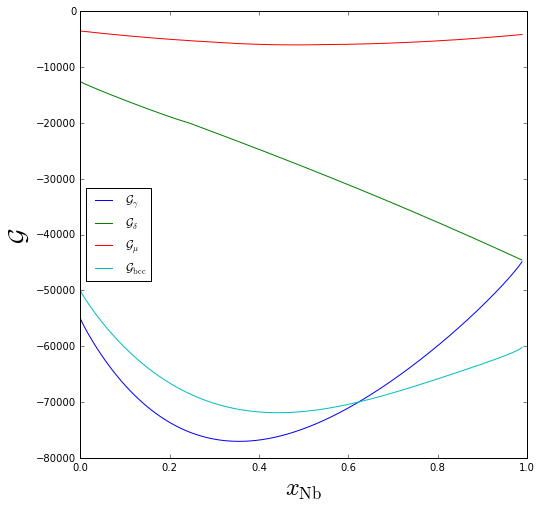

In [10]:
# plot Gibbs energy curves for fixed x_Mo = 1%
# using numerically efficient system-composition expressions
Gg = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), g_gamma, modules='numpy')
Gd = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), g_delta, modules='numpy')
Gu = lambdify((MU_XMO, MU_XNB, MU_XNI), g_mu, modules='numpy')
Gb = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), g_bcc, modules='numpy')

GX = []
GY = []
DX = []
DY = []
UX = []
UY = []
BX = []
BY = []

for xnb in np.linspace(epsilon,1,1001):
    xmo = 0.01
    xni = 1-xmo-xnb
    #print "(%4.2f, %4.2f,%5.2f)"%(xmo,xnb,xni)
    if xni>0:
        UX.append(xnb)
        GY.append(Gg(xmo,xnb,xni))
        DY.append(Gd(xmo,xnb,xni))
        UY.append(Gu(xmo,xnb,xni))
        BY.append(Gb(xmo,xnb,xni))

plt.figure(figsize=(8, 8))
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$\mathcal{G}$', fontsize=24)
plt.plot(UX, GY, label=r'$\mathcal{G}_\gamma$')
plt.plot(UX, DY, label=r'$\mathcal{G}_\delta$')
plt.plot(UX, UY, label=r'$\mathcal{G}_\mu$')
plt.plot(UX, BY, label=r'$\mathcal{G}_\mathrm{bcc}$')
plt.legend(loc='best')

## Mathematica output

In [11]:
# from sympy.printing.mathematica import mathematica_code as mcode
# print "G_gamma:"
# print mcode(g_gamma)
# print "\nG_mu:"
# print mcode(g_mu)
# print "\nG_delta:"
# print mcode(g_delta)
# print "\nG_BCC:"
# print mcode(g_bcc)

## Partial Derivatives

In [12]:
# First derivatives
dGgam_dxMo = diff(g_gamma, GAMMA_XMO)
dGgam_dxNb = diff(g_gamma, GAMMA_XNB)
dGgam_dxNi = diff(g_gamma, GAMMA_XNI)

dGdel_dxMo = diff(g_delta, DELTA_XMO)
dGdel_dxNb = diff(g_delta, DELTA_XNB)
dGdel_dxNi = diff(g_delta, DELTA_XNI)

dGmu_dxMo = diff(g_mu, MU_XMO)
dGmu_dxNb = diff(g_mu, MU_XNB)
dGmu_dxNi = diff(g_mu, MU_XNI)

dGbcc_dxMo = diff(g_bcc, BCC_XMO)
dGbcc_dxNb = diff(g_bcc, BCC_XNB)
dGbcc_dxNi = diff(g_bcc, BCC_XNI)

# Second derivatives
d2Ggam_dxMo2 = diff(dGgam_dxMo, GAMMA_XMO)
d2Ggam_dxNb2 = diff(dGgam_dxNb, GAMMA_XNB)
d2Ggam_dxNi2 = diff(dGgam_dxNi, GAMMA_XNI)

d2Gdel_dxMo2 = diff(dGdel_dxMo, DELTA_XMO)
d2Gdel_dxNb2 = diff(dGdel_dxNb, DELTA_XNB)
d2Gdel_dxNi2 = diff(dGdel_dxNi, DELTA_XNI)

d2Gmu_dxMo2 = diff(dGmu_dxMo, MU_XMO)
d2Gmu_dxNb2 = diff(dGmu_dxNb, MU_XNB)
d2Gmu_dxNi2 = diff(dGmu_dxNi, MU_XNI)

d2Gbcc_dxMo2 = diff(dGbcc_dxMo, BCC_XMO)
d2Gbcc_dxNb2 = diff(dGbcc_dxNb, BCC_XNB)
d2Gbcc_dxNi2 = diff(dGbcc_dxNi, BCC_XNI)

## C output

In [13]:
codegen([# Gibbs energies
         ('g_gam',g_gamma), ('g_mu',g_mu), ('g_del',g_delta), ('g_bcc',g_bcc),
         # First derivatives
         ('dg_gam_dxMo',dGgam_dxMo), ('dg_gam_dxNb',dGgam_dxNb), ('dg_gam_dxNi',dGgam_dxNi),
         ('dg_del_dxMo',dGdel_dxMo), ('dg_del_dxNb',dGdel_dxNb), ('dg_del_dxNi',dGdel_dxNi),
         ('dg_mu_dxMo',dGmu_dxMo), ('dg_mu_dxNb',dGmu_dxNb), ('dg_mu_dxNi',dGmu_dxNi),
         ('dg_bcc_dxMo',dGbcc_dxMo), ('dg_bcc_dxNb',dGbcc_dxNb), ('dg_bcc_dxNi',dGbcc_dxNi),
         # Second derivatives
         ('d2g_gam_dxMo2',d2Ggam_dxMo2), ('d2g_gam_dxNb2',d2Ggam_dxNb2), ('d2g_gam_dxNi2',d2Ggam_dxNi2),
         ('d2g_del_dxMo2',d2Gdel_dxMo2), ('d2g_del_dxNb2',d2Gdel_dxNb2), ('d2g_del_dxNi2',d2Gdel_dxNi2),
         ('d2g_mu_dxMo2', d2Gmu_dxMo2),  ('d2g_mu_dxNb2', d2Gmu_dxNb2),  ('d2g_mu_dxNi2', d2Gmu_dxNi2),
         ('d2g_bcc_dxMo2',d2Gbcc_dxMo2), ('d2g_bcc_dxNb2',d2Gbcc_dxNb2), ('d2g_bcc_dxNi2',d2Gbcc_dxNi2)],
        language='C', prefix='energy625', project='ALLOY625', to_files=True)

# Generate a phase diagram

This system has Lagrangian energy density

$$\mathcal{L} = \sum_pn_pG_p - \sum_i\mu_i\left[\sum_pn_px_{p,i} - N_i\right]$$

with phase fraction $n_p$, Gibbs energies (per phase) $G_p$, chemical potentials (per species) $\mu_i$, and mole fractions (per species and per phase) $x_{p,i}$. Note that the $\mu_i$ are the Lagrange multipliers of the constraint of mass conservation.

To generate the phase diagram, this equation is solved for the equilibrium compositions, chemical potentials, and phase fractions, accomplished by setting the partial derivatives of $\mathcal{L}$ with respect to each unknown equal to zero. The $G_p$ are taken from the Calphad database, and $N_i$ are the system composition corresponding to a point on the Gibbs simplex.

Therefore, we have seven knowns:
* 4 from $G$ ($G_\gamma$, $G_\delta$, $G_\mu$, $G_\mathrm{BCC}$)
* 3 from $N$ ($N_\mathrm{Mo}$, $N_\mathrm{Nb}$, $N_\mathrm{Ni}$)

This leaves nineteen variables: 
* 3 from $\mu$ ($\mu_\mathrm{Mo}$, $\mu_\mathrm{Nb}$, $\mu_\mathrm{Ni}$)
* 4 from $n$ ($n_\gamma$, $n_\delta$, $n_\mu$, $n_\mathrm{BCC}$)
* 3 from $x_\gamma$ ($x_{\gamma,\mathrm{Mo}}$, $x_{\gamma,\mathrm{Nb}}$, $x_{\gamma,\mathrm{Ni}}$) 
* 3 from $x_\delta$ ($x_{\delta,\mathrm{Mo}}$, $x_{\delta,\mathrm{Nb}}$, $x_{\delta,\mathrm{Ni}}$) 
* 3 from $x_\mu$ ($x_{\mu,\mathrm{Mo}}$, $x_{\mu,\mathrm{Nb}}$, $x_{\mu,\mathrm{Ni}}$)
* 3 from $x_\mathrm{BCC}$ ($x_{\mathrm{BCC},\mathrm{Mo}}$, $x_{\mathrm{BCC},\mathrm{Nb}}$,  $x_{\mathrm{BCC},\mathrm{Ni}}$)

The partial derivatives below are taken in exactly the order the variables appear above, producing nineteen equilibrium equations. To accelerate convergence of scipy.optimize.fsolve, the Jacobian matrix $J_{ij}=\frac{\partial f_i}{\partial x_j}$ is also computed -- that is, the partial derivative of each of the nineteen equations is taken with respect to each of the nineteen unknowns, in the same variable order as given above. This makes a $19\times19$ square symmetric matrix of partial derivatives: one equation per row, one variable per column.

## Numerically efficient expressions

In [14]:
# Gibbs energies
Gg = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), g_gamma, modules='numpy')
Gd = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), g_delta, modules='numpy')
Gu = lambdify((MU_XMO, MU_XNB, MU_XNI), g_mu, modules='numpy')
Gb = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), g_bcc, modules='numpy')

# First derivatives
dgdx0 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxMo, modules='numpy')
dgdx1 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxNb, modules='numpy')
dgdx2 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxNi, modules='numpy')

dddx0 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxMo, modules='numpy')
dddx1 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxNb, modules='numpy')
dddx2 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxNi, modules='numpy')

dudx0 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxMo, modules='numpy')
dudx1 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxNb, modules='numpy')
dudx2 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxNi, modules='numpy')

dbdx0 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxMo, modules='numpy')
dbdx1 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxNb, modules='numpy')
dbdx2 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxNi, modules='numpy')

# Second derivatives
d2gdx20 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxMo2, modules='numpy')
d2gdx21 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNb2, modules='numpy')
d2gdx22 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNi2, modules='numpy')

d2ddx20 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxMo2, modules='numpy')
d2ddx21 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNb2, modules='numpy')
d2ddx22 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNi2, modules='numpy')

d2udx20 = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxMo2, modules='numpy')
d2udx21 = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNb2, modules='numpy')
d2udx22 = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNi2, modules='numpy')

d2bdx20 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxMo2, modules='numpy')
d2bdx21 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNb2, modules='numpy')
d2bdx22 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNi2, modules='numpy')

## Solver

In [15]:
def commonTangentConc(C_Mo, C_Nb, C_Ni, guess):
    N = 19 # equations and unknowns
    it = 150 # iterations per equation, default is 100
    
    def equilibrium(u0, u1, u2, n0, n1, n2, n3, xg0, xg1, xg2, xd0, xd1, xd2, xu0, xu1, xu2, xb0, xb1, xb2):
        return [# dL/du
                -n0*xg0 - n1*xd0 - n2*xu0 - n3*xb0 + C_Mo,
                -n0*xg1 - n1*xd1 - n2*xu1 - n3*xb1 + C_Nb,
                -n0*xg2 - n1*xd2 - n2*xu2 - n3*xb2 + C_Ni,
                # dL/dn
                Gg(xg0,xg1,xg2) - u0*xg0 - u1*xg1 - u2*xg2,
                Gd(xd0,xd1,xd2) - u0*xd0 - u1*xd1 - u2*xd2,
                Gu(xu0,xu1,xu2) - u0*xu0 - u1*xu1 - u2*xu2,
                Gb(xb0,xb1,xb2) - u0*xb0 - u1*xb1 - u2*xb2,
                # dL/dxg
                n0*(dgdx0(xg0,xg1,xg2) - u0),
                n0*(dgdx1(xg0,xg1,xg2) - u1),
                n0*(dgdx2(xg0,xg1,xg2) - u2),
                # dL/dxd
                n1*(dddx0(xd0,xd1,xd2) - u0),
                n1*(dddx1(xd0,xd1,xd2) - u1),
                n1*(dddx2(xd0,xd1,xd2) - u2),
                # dL/dxu
                n2*(dudx0(xu0,xu1,xu2) - u0),
                n2*(dudx1(xu0,xu1,xu2) - u1),
                n2*(dudx2(xu0,xu1,xu2) - u2),
                # dL/dxb
                n3*(dbdx0(xb0,xb1,xb2) - u0),
                n3*(dbdx1(xb0,xb1,xb2) - u1),
                n3*(dbdx2(xb0,xb1,xb2) - u2)
                ]

    def Equilibrium(A):
        # Helper to convert from an array to named input
        return equilibrium(A[0], A[1], A[2], A[3], A[4], A[5], A[6], A[7], A[8], A[9], A[10], A[11], A[12], A[13], A[14], A[15], A[16], A[17], A[18])

    def jacobian(u0, u1, u2, n0, n1, n2, n3, xg0, xg1, xg2, xd0, xd1, xd2, xu0, xu1, xu2, xb0, xb1, xb2):
        
        return[
            [0,   0,   0,   -xg0,-xd0,-xu0,-xb0, -n0,0,0,-n1,0,0,-n2,0,0,-n3,0,0],
            [0,   0,   0,   -xg1,-xd1,-xu1,-xb1,  0,-n0,0,0,-n1,0,0,-n2,0,0,-n3,0],
            [0,   0,   0,   -xg2,-xd2,-xu2,-xb2,  0,0,-n0,0,0,-n1,0,0,-n2,0,0,-n3],
            [-xg0,-xg1,-xg2,0,0,0,0,dgdx0(xg0,xg1,xg2)-u0,dgdx1(xg0,xg1,xg2)-u1,dgdx2(xg0,xg1,xg2)-u2,0,0,0,0,0,0,0,0,0],
            [-xd0,-xd1,-xd2,0,0,0,0,0,0,0,dddx0(xd0,xd1,xd2)-u0,dddx1(xd0,xd1,xd2)-u1,dddx2(xd0,xd1,xd2)-u2,0,0,0,0,0,0],
            [-xu0,-xu1,-xu2,0,0,0,0,0,0,0,0,0,0,dudx0(xu0,xu1,xu2)-u0,dudx1(xu0,xu1,xu2)-u1,dudx2(xu0,xu1,xu2)-u2,0,0,0],
            [-xb0,-xb1,-xb2,0,0,0,0,0,0,0,0,0,0,0,0,0,dbdx0(xb0,xb1,xb2)-u0,dbdx1(xb0,xb1,xb2)-u1,dbdx2(xb0,xb1,xb2)-u2],
            [-n0, 0,   0,   dgdx0(xg0,xg1,xg2)-u0,0,0,0,n0*d2gdx20(xg0,xg1,xg2),0,0,0,0,0,0,0,0,0,0,0],
            [0,   -n0, 0,   dgdx1(xg0,xg1,xg2)-u1,0,0,0,0,n0*d2gdx21(xg0,xg1,xg2),0,0,0,0,0,0,0,0,0,0],
            [0,   0,   -n0, dgdx2(xg0,xg1,xg2)-u2,0,0,0,0,0,n0*d2gdx22(xg0,xg1,xg2),0,0,0,0,0,0,0,0,0],
            [-n1, 0,   0,   0,dddx0(xd0,xd1,xd2)-u0,0,0,0,0,0,n1*d2ddx20(xd0,xd1,xd2),0,0,0,0,0,0,0,0],
            [0,   -n1, 0,   0,dddx1(xd0,xd1,xd2)-u1,0,0,0,0,0,0,n1*d2ddx21(xd0,xd1,xd2),0,0,0,0,0,0,0],
            [0,   0,   -n1, 0,dddx2(xd0,xd1,xd2)-u2,0,0,0,0,0,0,0,n1*d2ddx22(xd0,xd1,xd2),0,0,0,0,0,0],
            [-n2, 0,   0,   0,0,dudx0(xu0,xu1,xu2)-u0,0,0,0,0,0,0,0,n2*d2udx20(xu0,xu1,xu2),0,0,0,0,0],
            [0,   -n2, 0,   0,0,dudx1(xu0,xu1,xu2)-u1,0,0,0,0,0,0,0,0,n2*d2udx21(xu0,xu1,xu2),0,0,0,0],
            [0,   0,   -n2, 0,0,dudx2(xu0,xu1,xu2)-u2,0,0,0,0,0,0,0,0,0,n2*d2udx22(xu0,xu1,xu2),0,0,0],
            [-n3, 0,   0,   0,0,0,dbdx0(xb0,xb1,xb2)-u0,0,0,0,0,0,0,0,0,0,n3*d2bdx20(xb0,xb1,xb2),0,0],
            [0,   -n3, 0,   0,0,0,dbdx1(xb0,xb1,xb2)-u1,0,0,0,0,0,0,0,0,0,0,n3*d2bdx21(xb0,xb1,xb2),0],
            [0,   0,   -n3, 0,0,0,dbdx2(xb0,xb1,xb2)-u2,0,0,0,0,0,0,0,0,0,0,0,n3*d2bdx22(xb0,xb1,xb2)]
        ]

    def Jacobian(A):
        return jacobian(A[0], A[1], A[2], A[3], A[4], A[5], A[6], A[7], A[8], A[9], A[10], A[11], A[12], A[13], A[14], A[15], A[16], A[17], A[18])

    return fsolve(func=Equilibrium, x0=guess, fprime=Jacobian, maxfev=N*it)

In [16]:
# Initial condition for gamma-delta coexistence field
# Note: Python tuples () are immutable lists [] are mutable. Use tuples for default values.
guessA = (1.0, 1.0,   1.0,        # Mo, Nb, Ni potentials
         0.5-epsilon, 0.5-epsilon, epsilon,epsilon,# gamma, delta, mu, bcc fractions
         0.1,  0.05,  0.85,     # gamma comp
         0.2,  0.2,   0.6,      # delta comp
         0.01, 0.525, 0.465,    # mu comp
         0.5,  0.5,   epsilon)        # bcc comp

# Initial condition for delta-mu coexistence field
guessB = (1.0, 1.0,   1.0,        # Mo, Nb, Ni potentials
         epsilon, 0.475, 0.475, 0.05-epsilon,# gamma, delta, mu, bcc fractions
         0.1,  0.05,  0.85,     # gamma comp
         0.2,  0.2,   0.6,      # delta comp
         0.01, 0.525, 0.465,    # mu comp
         0.5,  0.5,   epsilon)        # bcc comp
# Initial condition for mu-BCC coexistence field
guessC = (1.0,  1.0,  1.0,        # Mo, Nb, Ni potentials
         epsilon,0.05-epsilon, 0.475, 0.475,# gamma, delta, mu, bcc fractions
         0.1,  0.05,  0.85,     # gamma comp
         0.2,  0.2,   0.6,      # delta comp
         0.01, 0.525, 0.465,    # mu comp
         0.5,  0.5,   epsilon)        # bcc comp

# Initial condition for delta-BCC coexistence field
guessD = (1.0,  1.0,  1.0,        # Mo, Nb, Ni potentials
         epsilon, 0.475, 0.05-epsilon, 0.475,# gamma, delta, mu, bcc fractions
         0.1,  0.05,  0.85,     # gamma comp
         0.2,  0.2,   0.6,      # delta comp
         0.01, 0.525, 0.465,    # mu comp
         0.5,  0.5,   epsilon)        # bcc comp

# Initial condition for delta-mu-BCC coexistence field
guessE = (1.0, 1.0,   1.0,        # Mo, Nb, Ni potentials
         epsilon, 0.34-epsilon, 0.33, 0.33,# gamma, delta, mu, bcc fractions
         0.1,  0.05,  0.85,     # gamma comp
         0.2,  0.2,   0.6,      # delta comp
         0.01, 0.525, 0.465,    # mu comp
         0.5,  0.5,   epsilon)        # bcc comp

In [ ]:
def computeKernel(n):
    r = n / density
    xnb = (r + epsilon) / (density-1)
    s = n - r * density
    xmo = (s + epsilon) / (density-1)
    xni = 1 - xmo - xnb

    if xni > 0:
        # Choose an appropriate guess for this composition region
        guess = guessE  

        if xni > 0.725:
            # gamma-delta coexistence, field A
            guess = guessA
        elif xmo<0.025+(0.45/0.025)*(xnb-0.5):
            # mu-BCC coexistence, field C
            guess = guessC
        elif xmo<0.025*(xnb-0.225)/0.225:
            # delta-mu coexistence, field B
            guess = guessB
        elif xmo>0.475*(xnb-0.25)/(0.525-0.25):
            # delta-BCC coexistence, field D
            guess = guessD

        # Solve the common tangent construction
        result = []
        result.append((xmo, xnb, xni))
        result.append(commonTangentConc(xmo, xnb, xni, guess))
        return result
    else:
        return [0]*22

In [ ]:
# triangle bounding the Gibbs simplex
XT = [0.0, 1.0, 0.5, 0.0]
YT = [0.0, 0.0,rt32, 0.0]

XG = [] # array of Mo concentrations
YG = [] # array of Nb concentrations
XD = [] # (gamma, delta, mu, bcc)
YD = []
XU = []
YU = []
XB = []
YB = [] 

# Plot domains corresponding to the test points
XA = []
YA = []
XB = []
YB = []
XC = []
YC = []
XD = []
YD = []
XE = []
YE = []
XX = []
YX = []

density = 1001
threshold = 0.95

if __name__ == '__main__':
    start = time.clock()

    bar = FloatProgress(min=0,max=density*(density-1)/2) 
    display(bar)

    pool = Pool(6)

    m = 0
    for result in pool.map(computeKernel, range(density**2)):
        xmo,   xnb,   xni, \
        equ0,  equ1,  equ2, \
        eqn0,  eqn1,  eqn2, eqn3, \
        eqxg0, eqxg1, eqxg2, \
        eqxd0, eqxd1, eqxd2, \
        eqxu0, eqxu1, eqxu2, \
        eqxb0, eqxb1, eqxb2 = list(chain.from_iterable(result))

        if xni+epsilon > 0:
            if xni > 0.725:
                # gamma-delta coexistence, field A
                XA.append(xnb + xmo/2)
                YA.append(rt32*xmo)
            elif xmo<0.025+(0.45/0.025)*(xnb-0.5):
                # mu-BCC coexistence, field C
                XC.append(xnb + xmo/2)
                YC.append(rt32*xmo)
            elif xmo<0.025*(xnb-0.225)/0.225:
                # delta-mu coexistence, field B
                XB.append(xnb + xmo/2)
                YB.append(rt32*xmo)
            elif xmo>0.475*(xnb-0.25)/(0.525-0.25):
                # delta-BCC coexistence, field D
                XD.append(xnb + xmo/2)
                YD.append(rt32*xmo)
            else:
                # delta-mu-BCC coexistence, field E
                XE.append(xnb + xmo/2)
                YE.append(rt32*xmo)

            # Store points for the phase diagram
            nsum = eqn0 + eqn1 + eqn2 + eqn3
            if nsum > threshold:
                if eqxg0+epsilon>0 and eqxg1+epsilon>0 and eqxg2+epsilon>0 and eqxg0+eqxg1+eqxg2-epsilon<1:
                    XG.append(eqxg1 + eqxg0/2)
                    YG.append(rt32*eqxg0)

                if eqxd0+epsilon>0 and eqxd1+epsilon>0 and eqxd2+epsilon>0 and eqxd0+eqxd1+eqxd2-epsilon<1:
                    XD.append(eqxd1 + eqxd0/2)
                    YD.append(rt32*eqxd0)

                if eqxu0+epsilon>0 and eqxu1+epsilon>0 and eqxu2+epsilon>0 and eqxu0+eqxu1+eqxu2-epsilon<1:
                    XU.append(eqxu1 + eqxu0/2)
                    YU.append(rt32*eqxu0)

                if eqxb0+epsilon>0 and eqxb1+epsilon>0 and eqxb2+epsilon>0 and eqxb0+eqxb1+eqxb2-epsilon<1:
                    XB.append(eqxb1 + eqxb0/2)
                    YB.append(rt32*eqxb0)
            m += 1
        bar.value = m

    runtime = time.clock() - start
    print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

/users/tnk10/.conda/envs/mmsp/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/users/tnk10/.conda/envs/mmsp/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/users/tnk10/.conda/envs/mmsp/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/users/tnk10/.conda/envs/mmsp/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWa

In [ ]:
# Plot filtered phase compositions
pltsize = 10
plt.figure(figsize=(pltsize, rt32*pltsize))
plt.title("Mo-Nb-Ni at %.0f K"%temp, fontsize=18)
plt.xlim([0,1])
plt.ylim([0,rt32])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Mo}$', fontsize=24)
plt.plot(XT, YT, '-k')
plt.scatter(XXG, XYG, color='red',   label=r'$\gamma$')
plt.scatter(XXD, XYD, color='green', label=r'$\delta$')
plt.scatter(XXU, XYU, color='blue',  label=r'$\mu$')
plt.scatter(XXB, XYB, color='yellow',label='BCC')
plt.legend(loc='best')
plt.show()

In [ ]:
# Plot domains corresponding to the test points
plt.figure(figsize=(pltsize, rt32*pltsize))
plt.title("Guess Domains", fontsize=18)
plt.xlim([0,1])
plt.ylim([0,rt32])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Mo}$', fontsize=24)
plt.plot(XT, YT, '-k')
plt.scatter(XA, YA, color='red',   label=r'A ($\gamma-\delta$)')
plt.scatter(XB, YB, color='green', label=r'B ($\gamma-\mu$)')
plt.scatter(XC, YC, color='blue',  label=r'C ($\mu-$BCC)')
plt.scatter(XD, YD, color='yellow',label=r'D ($\delta-$BCC)')
plt.scatter(XE, YE, color='magenta',label=r'E ($\delta-\mu-$BCC)')
plt.scatter(XX, YX, color='cyan',label=r'X (previous)')
plt.legend(loc='best')
plt.show()